Тут ми спробуємо провести кластеризацію текстів ПІСЛЯ зменшення словника

In [1]:
import pandas as pd
import numpy as np
from requests_finder import load_request, contains_mention
import re

# Load data. Choose random 5000 rows

In [2]:
df_tags = pd.read_excel("home_appliances_with_tags.xlsx", index_col=0)
print(f"Loaded {df_tags.shape[0]} rows")

df_rus = pd.read_excel("home_appliances_rus_reduced.xlsx", index_col=0)
print(f"Loaded {df_rus.shape[0]} rows")

Loaded 6802 rows
Loaded 6802 rows


In [3]:
df_tags.head(1)

,title,text,source_type,source,date,home_appliances,MAIN_1: НЕРЕЛЕВАНТ,MAIN_1: Продаж нової техніки,MAIN_1: Продаж Б/У,MAIN_1: Ремонт/Поломки/Деталі,...,MAIN_2: Морозильна камера,MAIN_2: Духовка,MAIN_2: Варочні поверхні,MAIN_2: Витяжка,MAIN_2: Мікрохвильовка,MAIN_2: Кондиціонер,MAIN_2: Пилосос,MAIN_2: Бойлер,clean_text,lang
0,Инверторные кондиционеры | Купить в Москве по ...,<p>Инверторные кондиционеры | Купить в Москве ...,Социальные сети,facebook,2022-01-20 15:53:00,True,False,True,False,False,...,False,False,False,False,False,True,False,False,инверторные кондиционеры купить в москве по вы...,ru


In [4]:
df_rus.head(1)

,mention,clean_text,language,clipped_part_correct,translated_text,clean_rus,clean_rus_no_stopwords,index,lemmatized,lemmatized_with_pos,lemmatized_with_vectors_and_pos,reduced_with_pos,reduced_no_pos
0,Инверторные кондиционеры | Купить в Москве по ...,инверторные кондиционеры | купить в москве по ...,ru,NaN,инверторные кондиционеры | купить в москве по ...,инверторные кондиционеры купить в москве по вы...,инверторные кондиционеры купить москве выгодно...,0,инверторный кондиционер покупать москве выгодн...,инверторный_ADJ кондиционер_NOUN покупать_VERB...,кондиционер_NOUN покупать_VERB москве_NOUN выг...,кондиционер_NOUN купить_VERB москве_NOUN выгод...,кондиционер купить москве выгодный расценка ус...


In [5]:
lemmatized = {}

for index in df_rus.index:
    lemmatized[index] = df_rus.loc[index, "reduced_no_pos"].split(" ")

In [6]:
df_tags.drop(columns=['title', 'text', 'source_type', 'source', 
                      'date', 'home_appliances', 'clean_text', 'lang'], inplace=True)

In [7]:
all_tags = list(df_tags.columns)
tag2id = {tag:i for i, tag in enumerate(all_tags)}
id2tag = {i:tag for tag, i in tag2id.items()}

### Create vocabulary and replace tokens with ids

In [8]:
vocab = []
for tokens in lemmatized.values():
    for word in tokens:
        if word not in vocab:
            vocab.append(word)

print(len(vocab))

7113


In [9]:
word2ind = {}
ind2word = {}
n = 0
for word in vocab:
    word2ind[word] = n
    ind2word[n] = word
    n += 1

In [10]:
lemmatized_w_ids = {}
for key, tokens in lemmatized.items():
    new_tokens = []
    for word in tokens:
        new_tokens.append(word2ind[word])
    lemmatized_w_ids[key] = new_tokens

## Compute TF-IDF

In [218]:
import collections
import numpy as np


def compute_tf(text: list):
    #На вход берем текст в виде списка (list) слов
    #Считаем частотность всех терминов во входном массиве с помощью 
    #метода Counter библиотеки collections
    tf_text = collections.Counter(text)
    for i in tf_text:
        #для каждого слова в tf_text считаем TF путём деления
        #встречаемости слова на общее количество слов в тексте
        tf_text[i] = tf_text[i]/float(len(text))
    #возвращаем объект типа Counter c TF всех слов текста
    return tf_text

def compute_idf(word, corpus):
    #на вход берется слово, для которого считаем IDF
    #и корпус документов в виде списка списков слов
    #количество документов, где встречается искомый термин
    #считается как генератор списков
    N = len(corpus)
    try:
        return np.log10(N / sum([1 for words in corpus if word in words]))
    except ZeroDivisionError:
        return None
    
def compute_tfidf(corpus):
    N = len(corpus)
    tf_idf = {}
    
    print("Computing IDF")
    computed_idf = {}
    for ind in ind2word.keys():
        idf = compute_idf(ind, corpus.values())
        if idf is None:
            continue
        computed_idf[ind] = idf
    
    print("Computing TF")
    for i, text in corpus.items():
#         tf_idf_dictionary = {}
        computed_tf = compute_tf(text)
        
        for word in computed_tf:
            tf_idf[(i, word)] = computed_tf[word] * computed_idf[word]

#         tf_idf[i] = tf_idf_dictionary

    print("Done")
    return tf_idf

In [12]:
tf_idf = compute_tfidf(corpus=lemmatized_w_ids)

Computing IDF
Computing TF
Done


In [13]:
list(tf_idf.items())[:5]

[((0, 0), 0.06850634225279227),
 ((0, 1), 0.06868425030880235),
 ((0, 2), 0.17061942573951056),
 ((0, 3), 0.08452753790856336),
 ((0, 4), 0.036055853117192296)]

## Cluster TF-IDF

In [14]:
old2new_index = {}
new2old_index = {}
n = 0
for key in lemmatized_w_ids.keys():
    old2new_index[key] = n
    new2old_index[n] = key
    n += 1

In [227]:
#  lets create vectors for our texts
D = len(vocab)
N = len(lemmatized_w_ids.keys())

tf_idf_matrix = np.zeros((N, D))
for key, value in tf_idf.items():
    doc_id, token_id = key
    try:
        tf_idf_matrix[old2new_index[doc_id], token_id] = value
    except IndexError:
        print(doc_id, token_id)

### PCA

In [16]:
from sklearn.decomposition import FactorAnalysis, FastICA, IncrementalPCA
# from sklearn.
import matplotlib.pyplot as plt

Подивимось зменшимо розмірність до 5000-вимірного простору та поглянемо на оптимальну к-сть просторів

In [17]:
%%time
pca = IncrementalPCA(n_components=2000)
Z = pca.fit_transform(tf_idf_matrix)

Wall time: 1min 53s


In [18]:
print(f"Explained variance -- {pca.explained_variance_ratio_.sum()}")

Explained variance -- 0.9596686970927629


In [19]:
s = 0
for i, x in enumerate(pca.explained_variance_ratio_):
    s += x
    if s >= 0.9:
        break

print(f"90% of the variance is explained with n_components={i+1}")
optimal_n = i + 1
del i, s, x

90% of the variance is explained with n_components=1300


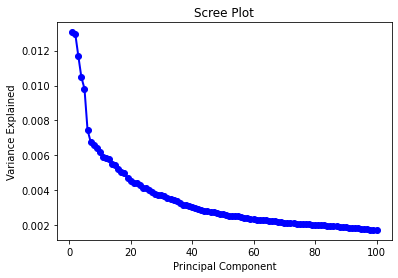

In [20]:
N = 100
PC_values = np.arange(pca.n_components_) + 1
PC_values = PC_values[:N]
plt.plot(PC_values, pca.explained_variance_ratio_[:N], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

На мою думку, приблизно після 15-ї компоненти наростання описаної варіаціїї не є таким стрімким.
Отже, спробуємо такі варіанти:
1. n = 3
2. n = 15
3. n = 742

#### N = 3

In [21]:
%%time
Z = IncrementalPCA(n_components=3).fit_transform(tf_idf_matrix)

Wall time: 1min 52s


In [22]:
# %matplotlib notebook

Plot all points

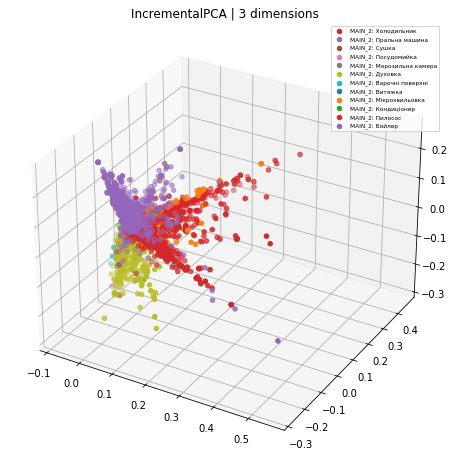

In [23]:
dims = (0, 1, 2)
# must be MAIN_1 or MAIN_2
tag_type = "MAIN_2"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for tag_name in df_tags.columns:
    if tag_type not in tag_name:
        continue
    
    indexes_old = df_tags[df_tags[tag_name]].index
    indexes_new = [old2new_index[i] for i in indexes_old]
    
    Z_temp = Z[indexes_new]
    ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
               c=f"C{tag2id[tag_name]}", label=tag_name)

plt.title('IncrementalPCA | 3 dimensions')
plt.legend(loc="best", fontsize="xx-small")
plt.show()

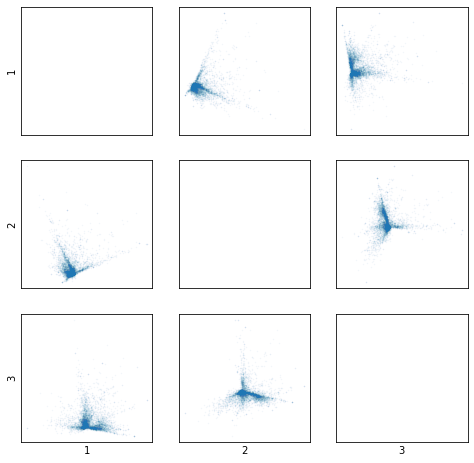

In [24]:
num_rows = 3
num_cols = 3

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=False, sharey=False, figsize=(8, 8))

for i in range(num_rows):
    for j in range(num_cols):
        if i == j:
            axs[i, j].axes.get_xaxis().set_ticks([])
            axs[i, j].axes.get_yaxis().set_ticks([])
            if i == num_rows - 1:
                axs[i, j].set_xlabel(str(j + 1), fontsize=10)

            if j == 0:
                axs[i, j].set_ylabel(str(i + 1), fontsize=10)
                
            continue
        
        axs[i, j].scatter(Z[:, i], Z[:, j], marker=".", alpha=0.05, s=1)
        axs[i, j].axes.get_xaxis().set_ticks([])
        axs[i, j].axes.get_yaxis().set_ticks([])
        
        if i == num_rows - 1:
            axs[i, j].set_xlabel(str(j + 1), fontsize=10)
            
        if j == 0:
            axs[i, j].set_ylabel(str(i + 1), fontsize=10)

plt.show()

plot points by the tag

In [25]:
def plot_points_by_tag_set(Z, tag_type, dims=(0, 1, 2)):
    # must be MAIN_1 or MAIN_2
    assert tag_type in ["MAIN_1", "MAIN_2"]
    
    curr_tags = [tag for tag in all_tags if tag_type in tag]
    colors = plt.cm.rainbow(np.linspace(0, 1, round(len(curr_tags) * 1.5)), alpha=1)

    nrows = len(curr_tags) // 2 + 1
    ncols = 2

    for i, tag_name in enumerate(curr_tags):
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(projection='3d')

        color = colors[i]

        nrow = i // 2
        ncol = i % 2

        indexes_old = df_tags[df_tags[tag_name]].index
        indexes_new = [old2new_index[i] for i in indexes_old]
        
        Z_temp = Z[[i for i in range(len(Z)) if i not in indexes_new]]
        ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
                   color="black", marker=".", alpha=0.05, label="Other texts", edgecolor=None)

        Z_temp = Z[indexes_new]
        ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
                   color=color, label=tag_name, marker="o", alpha=1)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

        plt.rcParams['grid.linewidth'] = 0.1

        plt.title(tag_name)
        plt.legend(loc="best", fontsize="xx-small")
        plt.show()

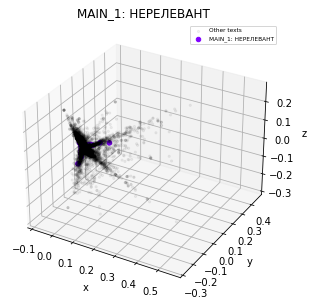

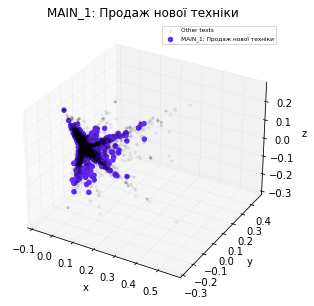

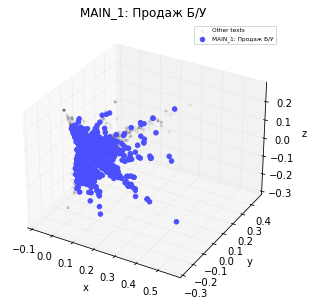

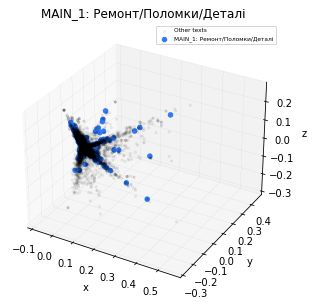

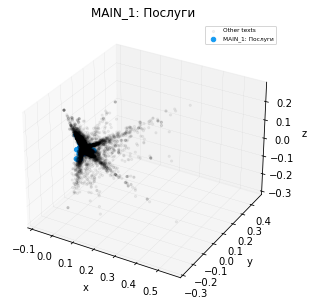

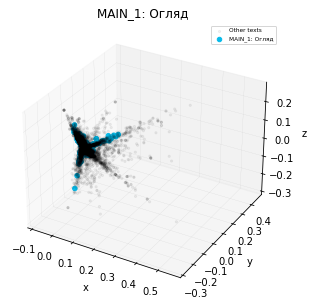

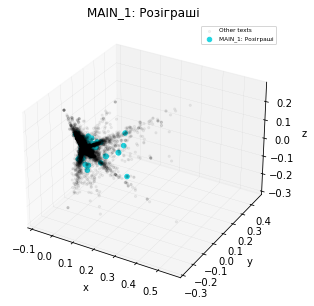

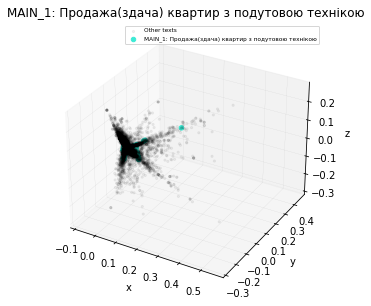

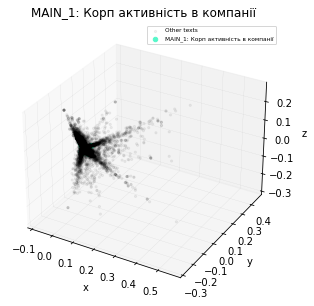

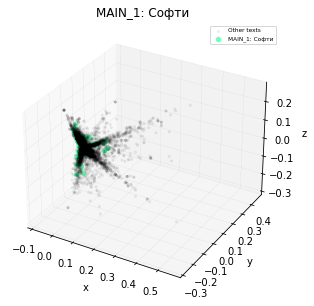

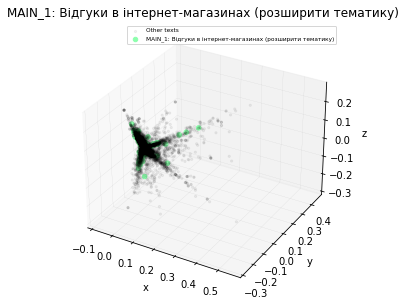

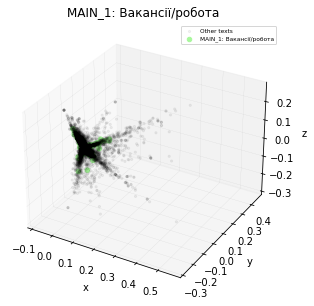

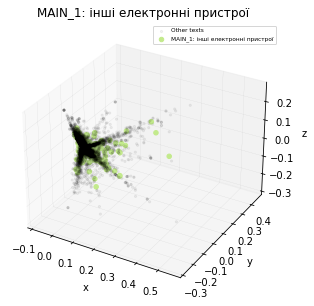

In [26]:
plot_points_by_tag_set(Z, "MAIN_1")

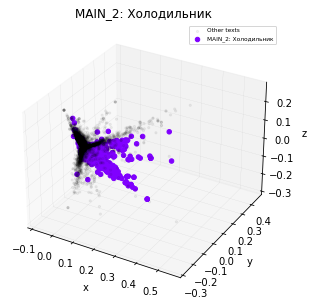

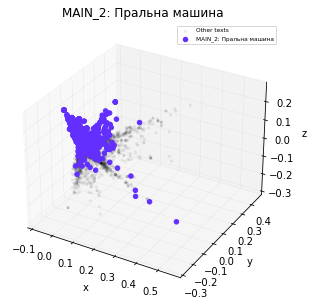

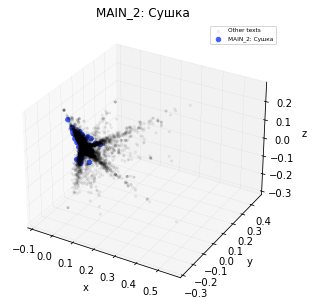

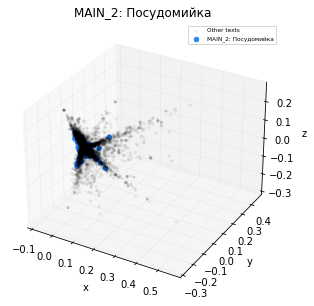

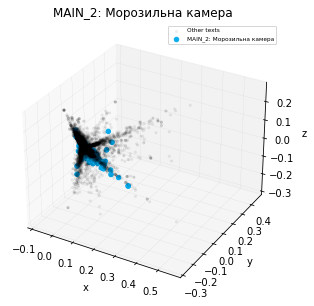

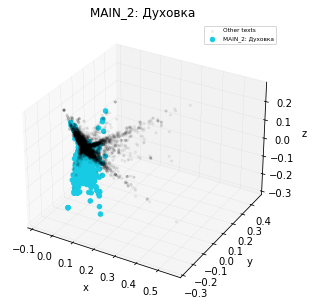

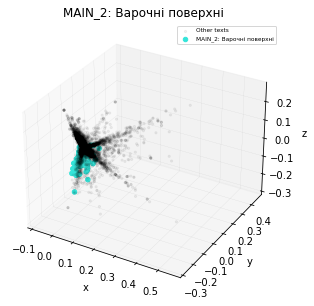

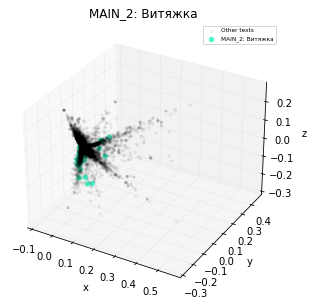

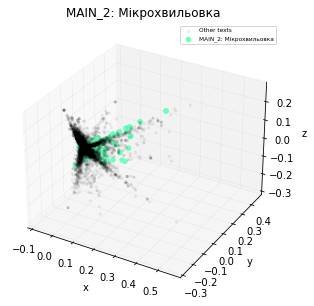

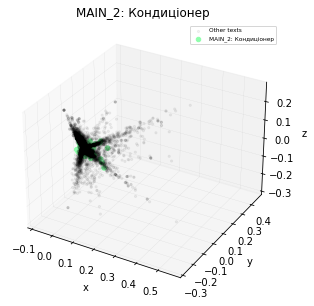

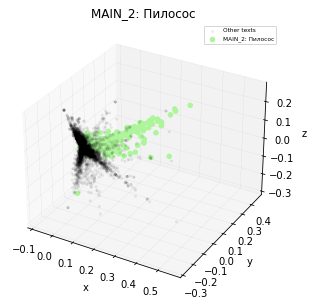

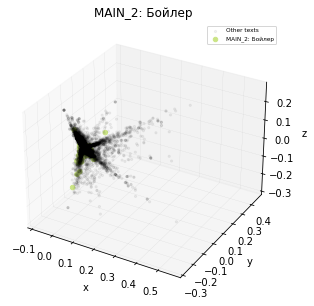

In [27]:
plot_points_by_tag_set(Z, "MAIN_2")

## Кластеризація

#### Kmeans

In [28]:
from sklearn.cluster import KMeans

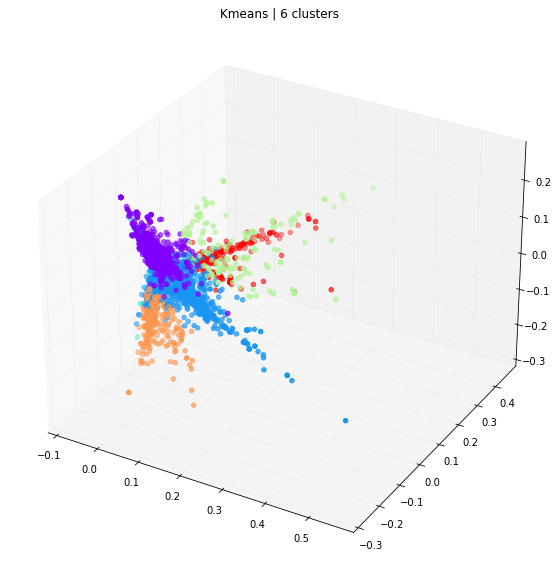

Wall time: 18.4 s


In [29]:
%%time
N = 6
kmeans = KMeans(n_clusters=N)
kmeans.fit(tf_idf_matrix)
clusters = kmeans.predict(tf_idf_matrix)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Kmeans | {N} clusters')
plt.show()

In [30]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax, kmin=1):
    sse = []
    for k in range(kmin, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

In [31]:
%%time
sse = calculate_WSS(tf_idf_matrix, kmin=1, kmax=15)

Wall time: 4min 24s


In [32]:
sse

[7.425132805828857,
 7.357254756029601,
 7.386026270880878,
 7.336202181846713,
 7.3090933749199625,
 7.293875394452822,
 7.303667555714412,
 7.297621047997325,
 7.346322723906816,
 7.287597778020971,
 7.285665132118965,
 4.5117488231242495,
 6.348735838832571,
 7.048956262825779,
 7.193172895921752]

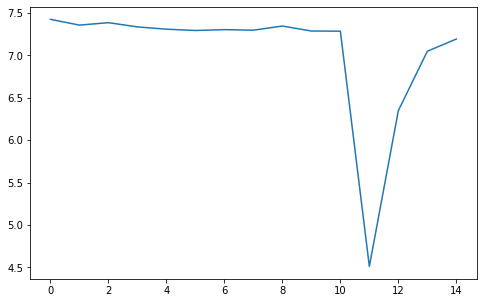

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(sse)
plt.show()

In [34]:
%%time
sse2 = calculate_WSS(tf_idf_matrix, kmin=15, kmax=25)

Wall time: 6min 28s


In [35]:
len(sse2)

11

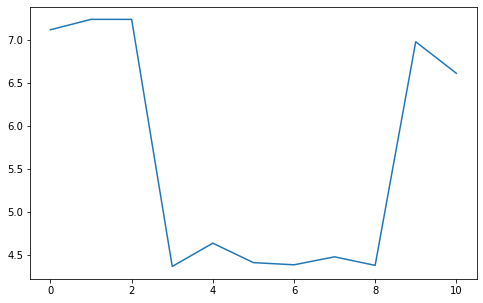

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(sse2)
plt.show()

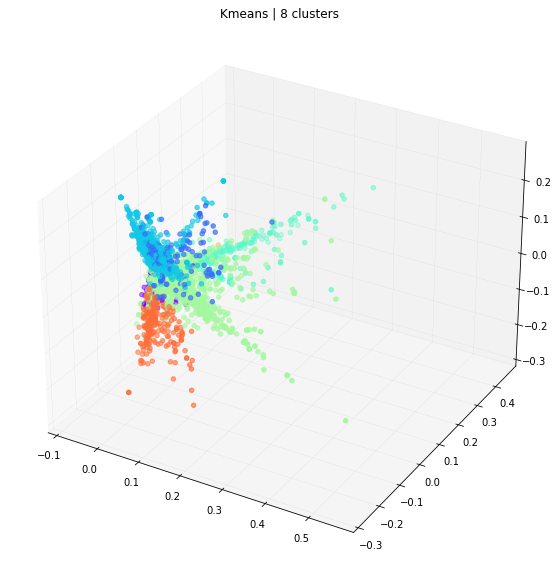

Wall time: 15.9 s


In [37]:
%%time
N = 8
kmeans = KMeans(n_clusters=N)
kmeans.fit(tf_idf_matrix)
clusters = kmeans.predict(tf_idf_matrix)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Kmeans | {N} clusters')
plt.show()

#### Hierarhical

In [38]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [39]:
%%time
linked = linkage(tf_idf_matrix, 'ward')

Wall time: 3min 1s


In [40]:
plt.figure(figsize=(8, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False)

plt.show()

KeyboardInterrupt: 

In [ ]:
methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
n = len(methods)
num_rows = max(1, n // 2)
if n % 8 > 0:
    num_rows += 1

fig, axs = plt.subplots(nrows=num_rows, ncols=2, sharex=False, figsize=(8, 5 * num_rows))

for i, method in enumerate(methods):
    nrow = i // 2
    ncol = i % 2
#     print(nrow, ncol)
    
    linked = linkage(Z, method)
    
    dendrogram(linked,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=False,
                ax=axs[nrow, ncol])
    
    axs[nrow, ncol].set_title(method)
    
plt.show()

In [ ]:
# %matplotlib notebook

In [ ]:
%%time
linked = linkage(tf_idf_matrix, 'ward')

t = 3.0

clusters = fcluster(linked, t=t, criterion="distance")
unique_clusters = np.unique(clusters)
print("Got {} unique clusters".format(unique_clusters.shape[0]))

# colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)), alpha=1)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Hierarchical (Ward) | {len(unique_clusters)} clusters')
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Hierarchical (Ward) | {len(unique_clusters)} clusters')
plt.show()

#### GMM

In [61]:
from sklearn.mixture import GaussianMixture as GM, BayesianGaussianMixture as BGM

In [ ]:
model = GM(n_components=10)
clusters = model.fit_predict(Z)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'GMM | {len(np.unique(clusters))} clusters')
plt.show()

Оскільки алгоритм ДУЖЕ довго виконується на даних з великою розмірністю, спробуємо спроектувати їх на 1300 головних компонент (адже саме стільки компонент пояснюють 90% варіації початкових даних)

In [58]:
%%time
pca = IncrementalPCA(n_components=1300)
Z_1300 = pca.fit_transform(tf_idf_matrix)

Wall time: 1min 36s


In [ ]:
%%time

model = GM(n_components=4, max_iter=1000, covariance_type="full")
clusters = model.fit_predict(Z_1300)

In [ ]:
# %matplotlib notebook

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'GMM | {len(np.unique(clusters))} clusters')
plt.show()

In [ ]:
%%time

model = BGM(n_components=8, max_iter=1000, weight_concentration_prior=2)
clusters = model.fit_predict(Z_1300)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'GMM | {len(np.unique(clusters))} clusters')
plt.show()

# Аналіз структури кластерів

## Kmeans

k=8

In [254]:
%%time
N = 8
kmeans = KMeans(n_clusters=N, random_state=0)
kmeans.fit(tf_idf_matrix)
clusters = kmeans.predict(tf_idf_matrix)

Wall time: 18.5 s


<IPython.core.display.Javascript object>


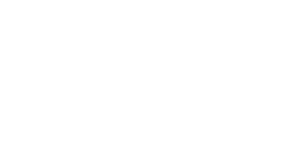

In [251]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Kmeans | {N} clusters')
plt.show()

In [255]:
tag_set = "MAIN_1"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters)
df_kmeans_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    df_temp = df_rus[clusters == cluster].copy()
    df_temp["length"] = df_temp.reduced_no_pos.apply(lambda x: len(x.split()))
    print(f"{cluster} -- mean length is {df_temp.length.mean()}")
    
    old_indexes_in_cluster = df_rus[clusters == cluster].index
    new_indexes_in_cluster = [old2new_index[i] for i in old_indexes_in_cluster]
    
    df_kmeans_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_kmeans_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_kmeans_display

0 -- mean length is 28.33259094283593
1 -- mean length is 9.28125
2 -- mean length is 20.842105263157894
3 -- mean length is 53.53906447534766
4 -- mean length is 12.570552147239264
5 -- mean length is 16.55452865064695
6 -- mean length is 26.60147601476015
7 -- mean length is 30.926829268292682


,#0-1347p.,#1-32p.,#2-247p.,#3-3955p.,#4-163p.,#5-541p.,#6-271p.,#7-246p.
MAIN_1: НЕРЕЛЕВАНТ,1,0,1,159,0,0,1,0
MAIN_1: Продаж нової техніки,406,32,63,2041,14,110,64,97
MAIN_1: Продаж Б/У,858,0,60,1021,63,455,152,50
MAIN_1: Ремонт/Поломки/Деталі,43,0,9,188,11,31,2,8
MAIN_1: Послуги,4,0,0,290,0,0,0,4
MAIN_1: Огляд,24,0,13,334,0,1,12,11
MAIN_1: Розіграші,8,0,3,247,0,7,3,3
MAIN_1: Продажа(здача) квартир з подутовою технікою,1,0,2,135,1,6,0,3
MAIN_1: Корп активність в компанії,0,0,0,53,0,0,0,0
MAIN_1: Софти,99,0,2,433,1,1,4,10


In [256]:
tag_set = "MAIN_2"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters)
df_kmeans_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    df_temp = df_rus[clusters == cluster].copy()
    df_temp["length"] = df_temp.reduced_no_pos.apply(lambda x: len(x.split()))
    print(f"{cluster} -- mean length is {df_temp.length.mean()}")
    
    old_indexes_in_cluster = df_rus[clusters == cluster].index
    new_indexes_in_cluster = [old2new_index[i] for i in old_indexes_in_cluster]
    
    df_kmeans_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_kmeans_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_kmeans_display

0 -- mean length is 28.33259094283593
1 -- mean length is 9.28125
2 -- mean length is 20.842105263157894
3 -- mean length is 53.53906447534766
4 -- mean length is 12.570552147239264
5 -- mean length is 16.55452865064695
6 -- mean length is 26.60147601476015
7 -- mean length is 30.926829268292682


,#0-1347p.,#1-32p.,#2-247p.,#3-3955p.,#4-163p.,#5-541p.,#6-271p.,#7-246p.
MAIN_2: Холодильник,33,13,1,1713,49,465,1,8
MAIN_2: Пральна машина,1336,13,3,1154,62,35,14,4
MAIN_2: Сушка,83,0,0,197,1,1,3,3
MAIN_2: Посудомийка,12,0,0,391,1,5,4,12
MAIN_2: Морозильна камера,5,0,1,371,1,45,2,0
MAIN_2: Духовка,27,3,0,971,6,18,269,176
MAIN_2: Варочні поверхні,1,2,0,300,0,2,16,144
MAIN_2: Витяжка,6,0,0,234,1,0,10,16
MAIN_2: Мікрохвильовка,5,0,2,414,22,15,1,4
MAIN_2: Кондиціонер,2,0,0,787,3,6,0,4


In [200]:
df_kmeans_display["#2-4002p."].sum()

7578

In [187]:
cluster_7_indexes_old = df_rus[clusters == 2].index
cluster_7_indexes_new = [old2new_index[i] for i in cluster_7_indexes_old]

In [207]:
len(cluster_7_indexes_new)

4002

In [189]:
tf_idf_matrix_7th_cluster = tf_idf_matrix[cluster_7_indexes_new]

In [190]:
pca = IncrementalPCA(n_components=3)
Z_for_7th_3d = pca.fit_transform(tf_idf_matrix_7th_cluster)

In [201]:
%%time
linked = linkage(tf_idf_matrix_7th_cluster, 'ward')

Wall time: 59.6 s


<IPython.core.display.Javascript object>


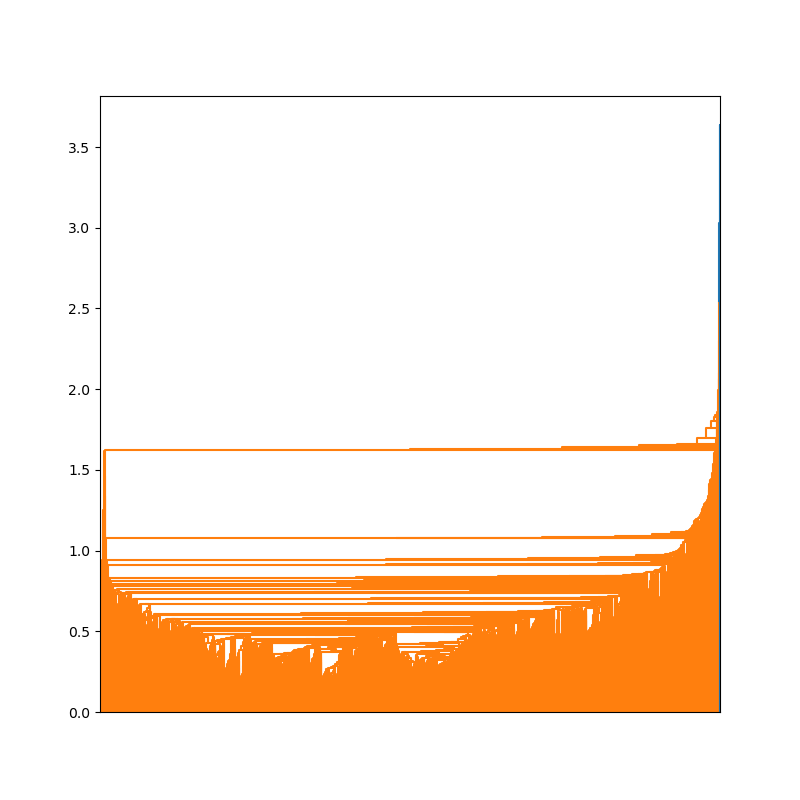

In [202]:
plt.figure(figsize=(8, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False, 
            no_labels=True)

plt.show()

<IPython.core.display.Javascript object>


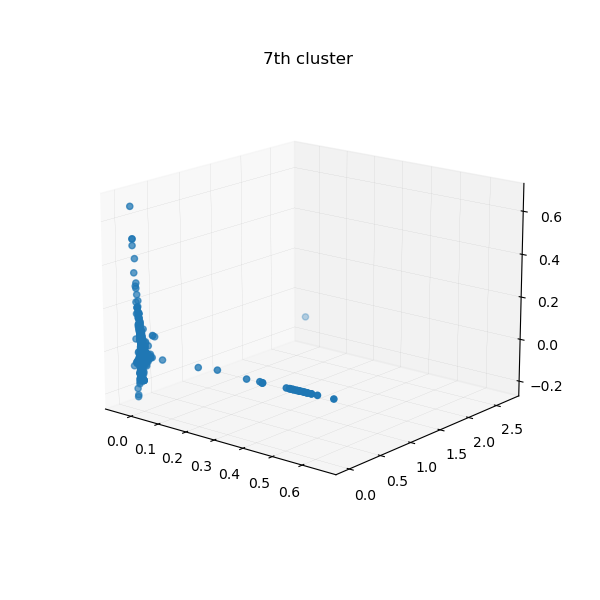

In [206]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_for_7th_3d[:, 0], Z_for_7th_3d[:, 1], Z_for_7th_3d[:, 2]) # plot the point (2,3,4) on the figure
plt.title(f'7th cluster')
plt.show()

### new tf-idf matrix for the 3rd cluster

In [214]:
len({k: v for k, v in lemmatized_w_ids.items() if k in cluster_7_indexes_old}.keys())

4002

In [222]:
tf_idf_7th_cluster = compute_tfidf({k: v for k, v in lemmatized_w_ids.items() if k in cluster_7_indexes_old})

Computing IDF
Computing TF
Done


In [225]:
vocab_in_7th = []
lemmatized_w_ids_for_7th = {k: v for k, v in lemmatized_w_ids.items() if k in cluster_7_indexes_old}

for index, words in lemmatized_w_ids_for_7th.items():
    for word in words:
        if word not in vocab_in_7th:
            vocab_in_7th.append(word)
            
print(len(vocab_in_7th))

6765


In [226]:
#  lets create vectors for our texts
D = len(vocab_in_7th)
N = len(lemmatized_w_ids_for_7th.keys())

tf_idf_matrix_7th_cluster = np.zeros((N, D))
for key, value in tf_idf_7th_cluster.items():
    doc_id, token_id = key
    try:
        tf_idf_matrix_7th_cluster[old2new_index[doc_id], token_id] = value
    except IndexError:
        print(doc_id, token_id)

In [221]:
tf_idf_matrix_7th_cluster

{(0, 0): 0.053245643723697104,
 (0, 1): 0.06153707697400839,
 (0, 2): 0.15890622862273882,
 (0, 3): 0.07877281224492065,
 (0, 4): 0.04127734602051396,
 (0, 5): 0.08554799792949656,
 (0, 6): 0.05670705622325085,
 (0, 7): 0.1006285318933369,
 (0, 8): 0.03329291624835373,
 (0, 9): 0.034165577421178504,
 (0, 10): 0.03531801939698822,
 (0, 11): 0.021626122430024427,
 (0, 12): 0.016151563145560183,
 (0, 13): 0.03531801939698822,
 (0, 14): 0.017606711845860712,
 (0, 15): 0.014489241973114735,
 (0, 16): 0.01353932150257252,
 (0, 17): 0.032259442033291084,
 (0, 18): 0.017388741255837285,
 (0, 19): 0.029678283653917243,
 (0, 20): 0.02801503521449627,
 (0, 21): 0.029081124730978146,
 (0, 22): 0.12211108760339635,
 (0, 23): 0.02235552297621429,
 (0, 24): 0.028440640648106967,
 (0, 25): 0.1227040945628433,
 (0, 26): 0.0467318482082362,
 (0, 27): 0.05102939224719105,
 (0, 28): 0.037236827160780056,
 (0, 29): 0.07595082197568136,
 (0, 30): 0.055953340485359514,
 (8, 55): 0.12500904554050957,
 (8, 35)

In [201]:
%%time
linked = linkage(tf_idf_matrix_7th_cluster, 'ward')

Wall time: 59.6 s


<IPython.core.display.Javascript object>


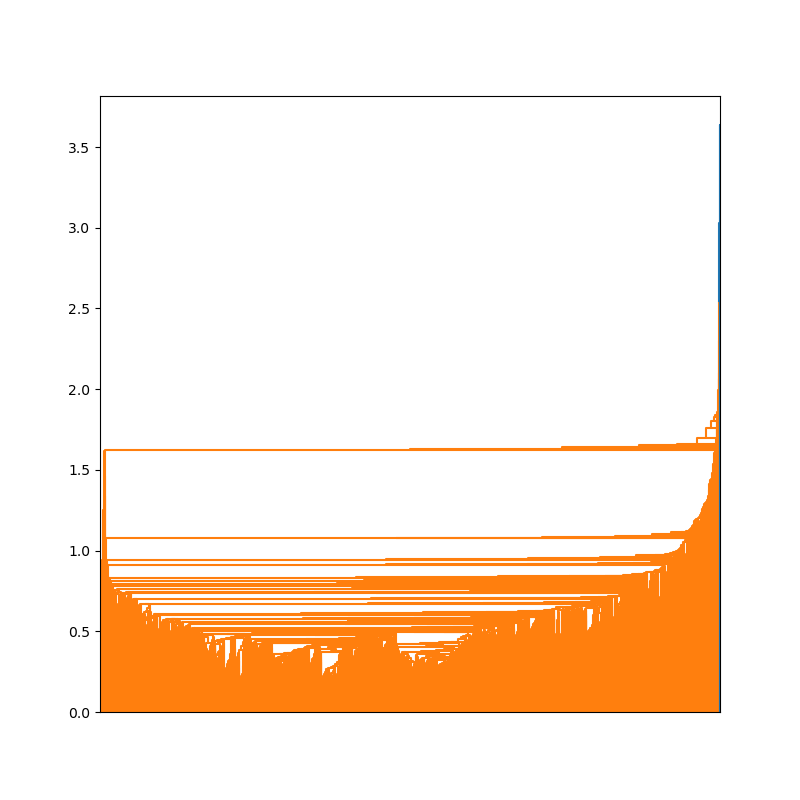

In [202]:
plt.figure(figsize=(8, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False, 
            no_labels=True)

plt.show()

<IPython.core.display.Javascript object>


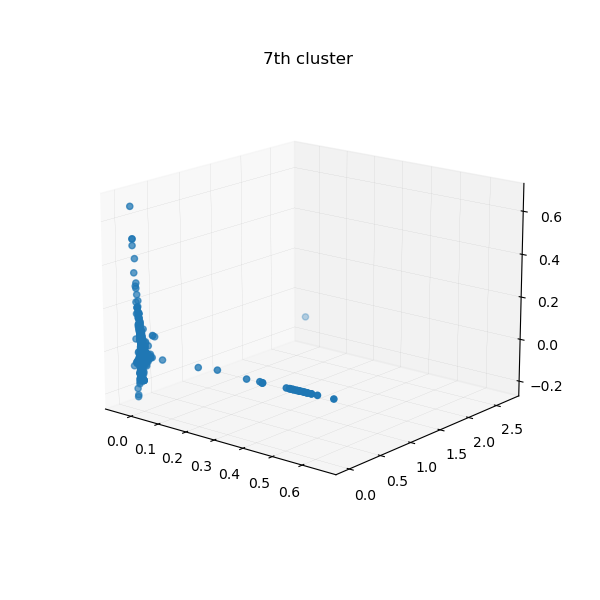

In [206]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_for_7th_3d[:, 0], Z_for_7th_3d[:, 1], Z_for_7th_3d[:, 2]) # plot the point (2,3,4) on the figure
plt.title(f'7th cluster')
plt.show()

In [55]:
%matplotlib notebook

Got 8 unique clusters


<IPython.core.display.Javascript object>


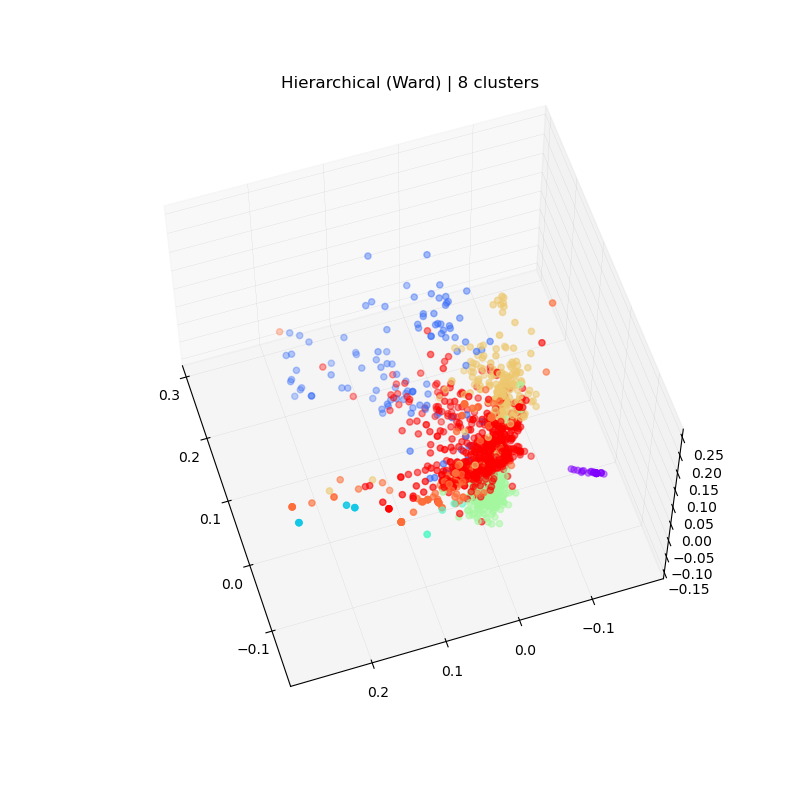

In [109]:
t = 1.8

clusters_inside_7th = fcluster(linked, t=t, criterion="distance")
unique_clusters = np.unique(clusters_inside_7th)
print("Got {} unique clusters".format(unique_clusters.shape[0]))

# colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)), alpha=1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_for_7th[:, 0], Z_for_7th[:, 1], Z_for_7th[:, 2],
           c=clusters_inside_7th, cmap="rainbow")
# ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Hierarchical (Ward) | {len(unique_clusters)} clusters')
plt.show()

In [59]:
Z_1300_7th_cluster = Z_1300[cluster_7_indexes_new]

In [195]:
pca = IncrementalPCA(n_components=1300)
Z_for_7th = pca.fit_transform(tf_idf_matrix_7th_cluster)

In [196]:
s = 0
for i, x in enumerate(pca.explained_variance_ratio_):
    s += x
    if s >= 0.9:
        break

print(f"90% of the variance is explained with n_components={i+1}")
optimal_n = i + 1
del i, s, x

90% of the variance is explained with n_components=1180


In [115]:
pca = IncrementalPCA(n_components=408)
Z_for_7th = pca.fit_transform(tf_idf_matrix_7th_cluster)

In [120]:
%%time

model = BGM(n_components=6, max_iter=5000, weight_concentration_prior=1)
clusters_inside_7th = model.fit_predict(Z_for_7th)

Wall time: 988 ms


In [118]:
pca = IncrementalPCA(n_components=3)
Z_for_7th_3d = pca.fit_transform(tf_idf_matrix_7th_cluster)

Got 6 unique clusters


<IPython.core.display.Javascript object>


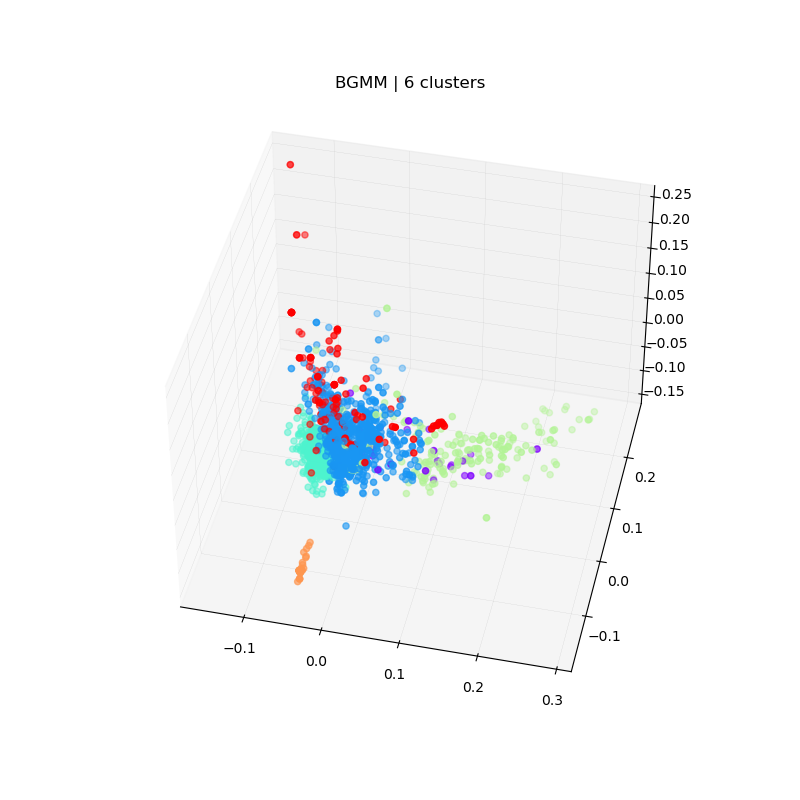

In [121]:
unique_clusters = np.unique(clusters_inside_7th)
print("Got {} unique clusters".format(unique_clusters.shape[0]))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_for_7th_3d[:, 0], Z_for_7th_3d[:, 1], Z_for_7th_3d[:, 2],
           c=clusters_inside_7th, cmap="rainbow")

plt.title(f'BGMM | {len(unique_clusters)} clusters')
plt.show()

In [ ]:
new_indexes_array = np.array(list(new2old_index.keys()))

In [137]:
tag_set = "MAIN_2"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters_inside_7th)
df_BGMM_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    print(sum(np.isin(clusters_inside_7th, 1)))
    new_indexes_in_cluster = [i for i, indicator in zip(cluster_7_indexes_new, np.isin(clusters_inside_7th, cluster)) \
                              if indicator]
    old_indexes_in_cluster = [new2old_index[i] for i in new_indexes_in_cluster]
    
    df_BGMM_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_BGMM_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_BGMM_display

728
728
728
728
728
728


,#0-37p.,#1-728p.,#2-288p.,#3-171p.,#4-29p.,#5-129p.
MAIN_2: Холодильник,1,20,3,3,0,6
MAIN_2: Пральна машина,36,723,288,171,29,125
MAIN_2: Сушка,0,57,16,5,0,5
MAIN_2: Посудомийка,0,10,1,0,0,1
MAIN_2: Морозильна камера,0,4,0,0,0,1
MAIN_2: Духовка,2,22,0,0,0,5
MAIN_2: Варочні поверхні,0,1,0,0,0,0
MAIN_2: Витяжка,1,1,0,0,0,4
MAIN_2: Мікрохвильовка,0,4,0,0,0,1
MAIN_2: Кондиціонер,0,2,0,0,0,0


In [125]:
np.isin(clusters_inside_7th, 1)

array([False,  True, False, ..., False,  True,  True])

## Hierarchical

Got 10 unique clusters


<IPython.core.display.Javascript object>


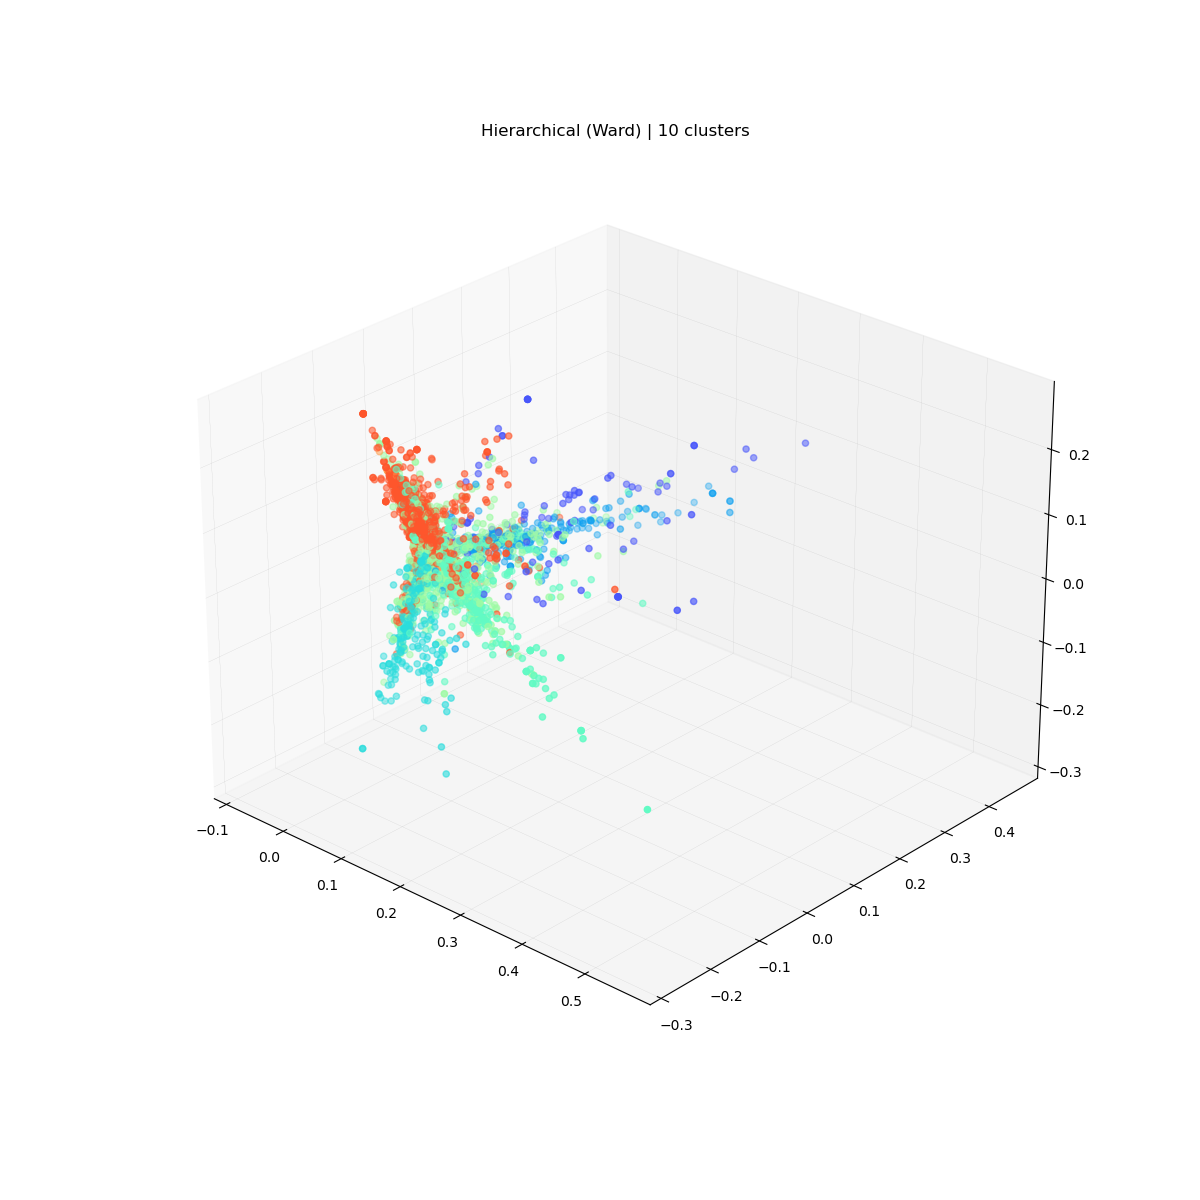

Wall time: 2min 50s


In [228]:
%%time
linked = linkage(tf_idf_matrix, 'ward')

t = 3.0

clusters = fcluster(linked, t=t, criterion="distance")
unique_clusters = np.unique(clusters)
print("Got {} unique clusters".format(unique_clusters.shape[0]))

# colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)), alpha=1)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Hierarchical (Ward) | {len(unique_clusters)} clusters')
plt.show()

In [229]:
tag_set = "MAIN_1"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters)
df_kmeans_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    df_temp = df_rus[clusters == cluster].copy()
    df_temp["length"] = df_temp.reduced_no_pos.apply(lambda x: len(x.split()))
    print(f"{cluster} -- mean length is {df_temp.length.mean()}")
    
    old_indexes_in_cluster = df_rus[clusters == cluster].index
    new_indexes_in_cluster = [old2new_index[i] for i in old_indexes_in_cluster]
    
    df_kmeans_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_kmeans_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_kmeans_display

,#1-27p.,#2-97p.,#3-433p.,#4-239p.,#5-749p.,#6-3780p.,#7-1p.,#8-22p.,#9-1453p.,#10-1p.
MAIN_1: НЕРЕЛЕВАНТ,0,0,2,0,1,141,0,0,18,0
MAIN_1: Продаж нової техніки,0,5,200,56,221,1830,0,22,493,0
MAIN_1: Продаж Б/У,0,28,102,135,509,989,0,0,896,0
MAIN_1: Ремонт/Поломки/Деталі,0,4,9,2,22,228,0,0,26,1
MAIN_1: Послуги,0,0,4,0,2,289,0,0,3,0
MAIN_1: Огляд,0,2,22,2,32,275,0,0,62,0
MAIN_1: Розіграші,0,0,26,3,9,220,0,0,13,0
MAIN_1: Продажа(здача) квартир з подутовою технікою,0,0,2,1,4,139,0,0,2,0
MAIN_1: Корп активність в компанії,0,0,0,0,0,52,0,0,1,0
MAIN_1: Софти,0,0,19,5,10,306,0,0,210,0


In [230]:
tag_set = "MAIN_2"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters)
df_kmeans_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    df_temp = df_rus[clusters == cluster].copy()
    df_temp["length"] = df_temp.reduced_no_pos.apply(lambda x: len(x.split()))
    print(f"{cluster} -- mean length is {df_temp.length.mean()}")
    
    old_indexes_in_cluster = df_rus[clusters == cluster].index
    new_indexes_in_cluster = [old2new_index[i] for i in old_indexes_in_cluster]
    
    df_kmeans_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_kmeans_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_kmeans_display

,#1-27p.,#2-97p.,#3-433p.,#4-239p.,#5-749p.,#6-3780p.,#7-1p.,#8-22p.,#9-1453p.,#10-1p.
MAIN_2: Холодильник,0,20,16,15,517,1594,0,9,112,0
MAIN_2: Пральна машина,0,17,26,29,139,1173,0,11,1225,1
MAIN_2: Сушка,0,1,0,6,13,147,0,0,121,0
MAIN_2: Посудомийка,0,0,3,4,20,387,0,0,11,0
MAIN_2: Морозильна камера,0,0,2,5,164,247,0,0,7,0
MAIN_2: Духовка,0,4,12,209,52,1098,0,2,93,0
MAIN_2: Варочні поверхні,0,0,0,23,6,423,0,0,13,0
MAIN_2: Витяжка,0,0,5,14,1,242,0,0,5,0
MAIN_2: Мікрохвильовка,27,43,7,4,24,316,0,0,42,0
MAIN_2: Кондиціонер,0,0,3,0,12,753,0,0,34,0


In [237]:
cluster_7_indexes_old = df_rus[clusters == 5].index
cluster_7_indexes_new = [old2new_index[i] for i in cluster_7_indexes_old]

In [238]:
len(cluster_7_indexes_new)

604

In [189]:
tf_idf_matrix_7th_cluster = tf_idf_matrix[cluster_7_indexes_new]

In [190]:
pca = IncrementalPCA(n_components=3)
Z_for_7th_3d = pca.fit_transform(tf_idf_matrix_7th_cluster)

In [201]:
%%time
linked = linkage(tf_idf_matrix_7th_cluster, 'ward')

Wall time: 59.6 s


<IPython.core.display.Javascript object>


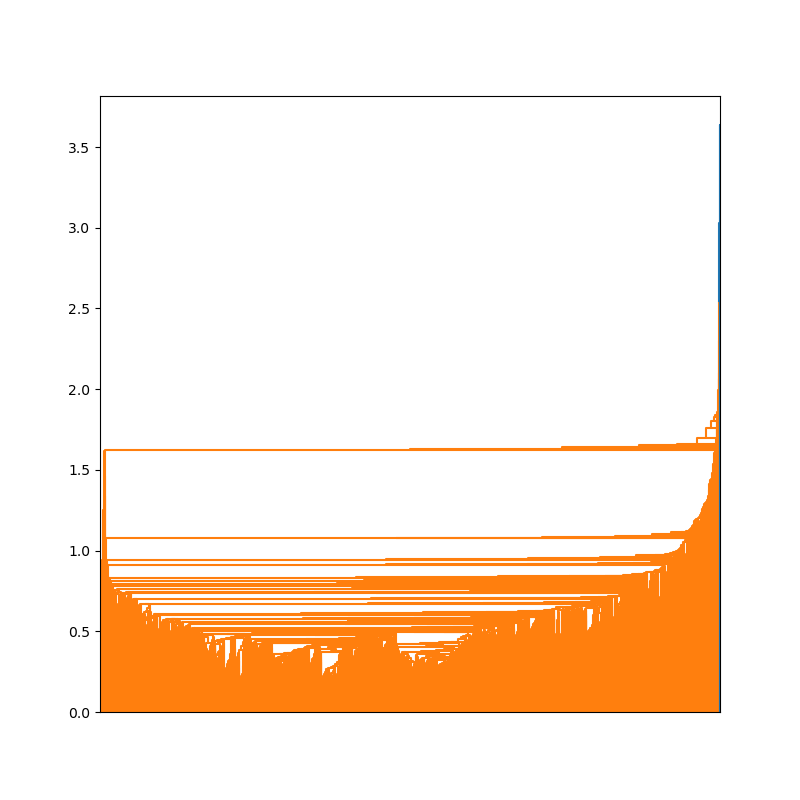

In [202]:
plt.figure(figsize=(8, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False, 
            no_labels=True)

plt.show()

<IPython.core.display.Javascript object>


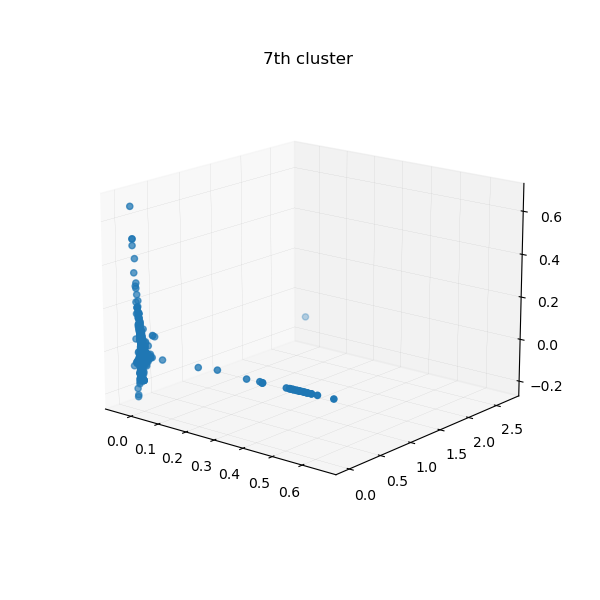

In [206]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_for_7th_3d[:, 0], Z_for_7th_3d[:, 1], Z_for_7th_3d[:, 2]) # plot the point (2,3,4) on the figure
plt.title(f'7th cluster')
plt.show()

## GMM

In [231]:
%%time

model = GM(n_components=8, max_iter=1000, covariance_type="full")
clusters = model.fit_predict(Z_1300)

Wall time: 27.9 s


<IPython.core.display.Javascript object>


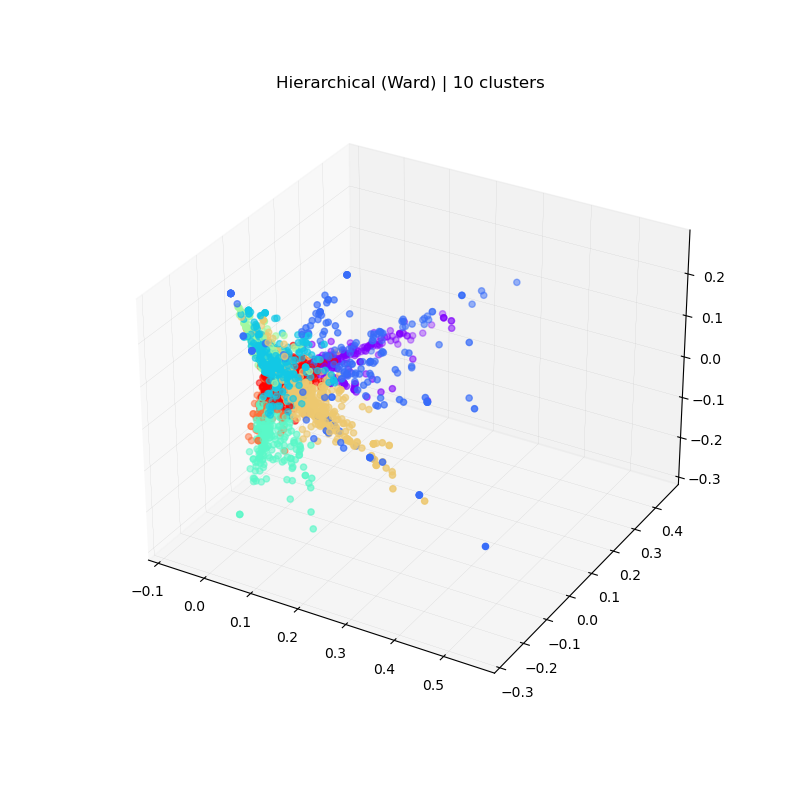

In [232]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=clusters, cmap="rainbow") # plot the point (2,3,4) on the figure
plt.title(f'Hierarchical (Ward) | {len(unique_clusters)} clusters')
plt.show()

In [249]:
tag_set = "MAIN_1"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters)
df_kmeans_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    df_temp = df_rus[clusters == cluster].copy()
    df_temp["length"] = df_temp.reduced_no_pos.apply(lambda x: len(x.split()))
    print(f"{cluster} -- mean length is {df_temp.length.mean()}")
    
    old_indexes_in_cluster = df_rus[clusters == cluster].index
    new_indexes_in_cluster = [old2new_index[i] for i in old_indexes_in_cluster]
    
    df_kmeans_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_kmeans_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_kmeans_display

0 -- mean length is 20.80314960629921
1 -- mean length is 10.658163265306122
2 -- mean length is 28.591216216216218
3 -- mean length is 26.3399209486166
4 -- mean length is 28.17467248908297
5 -- mean length is 16.77980132450331
6 -- mean length is 28.187878787878788
7 -- mean length is 53.33818810170328


,#0-254p.,#1-196p.,#2-592p.,#3-253p.,#4-687p.,#5-604p.,#6-165p.,#7-4051p.
MAIN_1: НЕРЕЛЕВАНТ,1,0,1,1,0,0,0,159
MAIN_1: Продаж нової техніки,68,10,185,62,178,149,61,2114
MAIN_1: Продаж Б/У,64,77,391,148,435,465,37,1042
MAIN_1: Ремонт/Поломки/Деталі,9,14,13,2,30,29,4,191
MAIN_1: Послуги,0,0,0,0,3,0,3,292
MAIN_1: Огляд,13,0,1,11,20,1,4,345
MAIN_1: Розіграші,6,0,4,3,5,4,2,247
MAIN_1: Продажа(здача) квартир з подутовою технікою,2,1,1,0,0,6,1,137
MAIN_1: Корп активність в компанії,0,0,0,0,0,0,0,53
MAIN_1: Софти,2,1,40,4,55,1,6,441


In [248]:
tag_set = "MAIN_2"
curr_tags = [tag for tag in all_tags if tag_set in tag]

unique_clusters = np.unique(clusters)
df_kmeans_display = pd.DataFrame(index=curr_tags)
for cluster in unique_clusters:
    df_temp = df_rus[clusters == cluster].copy()
    df_temp["length"] = df_temp.reduced_no_pos.apply(lambda x: len(x.split()))
    print(f"{cluster} -- mean length is {df_temp.length.mean()}")
    old_indexes_in_cluster = df_rus[clusters == cluster].index
    new_indexes_in_cluster = [old2new_index[i] for i in old_indexes_in_cluster]
    
    df_kmeans_display[f"#{cluster}-{len(old_indexes_in_cluster)}p."] = None
    
    for i, tag_name in enumerate(curr_tags):
        data_for_tag = df_rus[(np.isin(df_rus.index, old_indexes_in_cluster)) & \
                              (df_tags[tag_name])]
        
        df_kmeans_display.loc[tag_name, f"#{cluster}-{len(old_indexes_in_cluster)}p."] = data_for_tag.shape[0]
df_kmeans_display

0 -- mean length is 20.80314960629921
1 -- mean length is 10.658163265306122
2 -- mean length is 28.591216216216218
3 -- mean length is 26.3399209486166
4 -- mean length is 28.17467248908297
5 -- mean length is 16.77980132450331
6 -- mean length is 28.187878787878788
7 -- mean length is 53.33818810170328


,#0-254p.,#1-196p.,#2-592p.,#3-253p.,#4-687p.,#5-604p.,#6-165p.,#7-4051p.
MAIN_2: Холодильник,1,73,21,1,18,483,5,1681
MAIN_2: Пральна машина,4,70,564,8,678,78,2,1217
MAIN_2: Сушка,0,1,30,3,50,0,2,202
MAIN_2: Посудомийка,0,1,5,3,10,6,7,393
MAIN_2: Морозильна камера,1,1,2,2,3,48,0,368
MAIN_2: Духовка,0,8,20,251,19,17,111,1044
MAIN_2: Варочні поверхні,0,0,3,15,1,2,117,327
MAIN_2: Витяжка,0,1,9,8,0,0,9,240
MAIN_2: Мікрохвильовка,2,22,3,1,1,18,2,414
MAIN_2: Кондиціонер,0,2,1,0,2,8,1,788


In [239]:
cluster_7_indexes_old = df_rus[clusters == 7].index
cluster_7_indexes_new = [old2new_index[i] for i in cluster_7_indexes_old]

In [240]:
len(cluster_7_indexes_new)

4051

In [241]:
tf_idf_matrix_7th_cluster = tf_idf_matrix[cluster_7_indexes_new]

In [242]:
pca = IncrementalPCA(n_components=3)
Z_for_7th_3d = pca.fit_transform(tf_idf_matrix_7th_cluster)

In [243]:
%%time
linked = linkage(tf_idf_matrix_7th_cluster, 'ward')

Wall time: 1min 17s


<IPython.core.display.Javascript object>


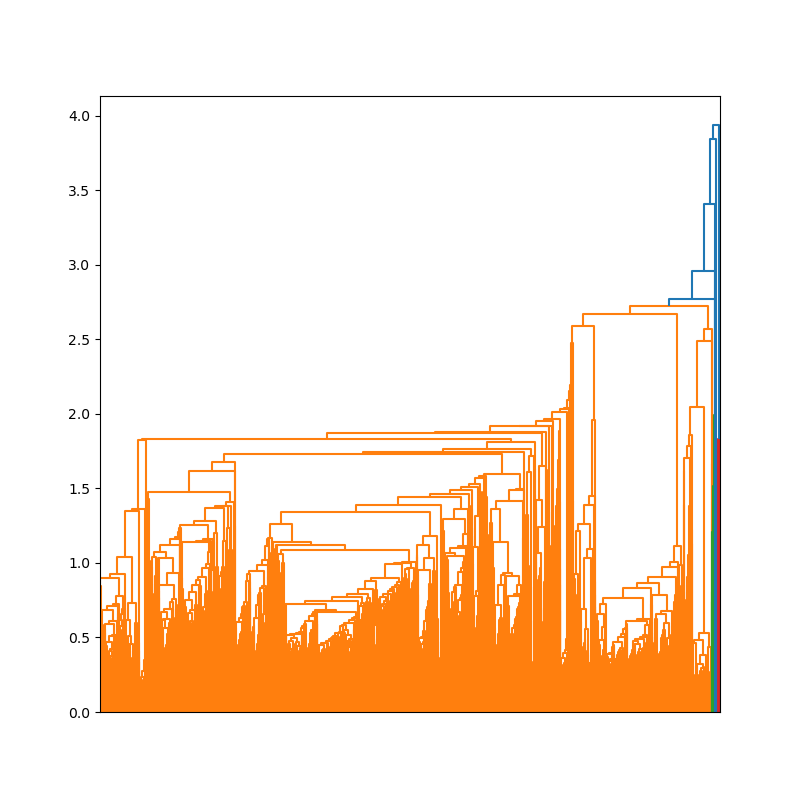

In [246]:
plt.figure(figsize=(8, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False, 
            no_labels=True)

plt.show()

<IPython.core.display.Javascript object>


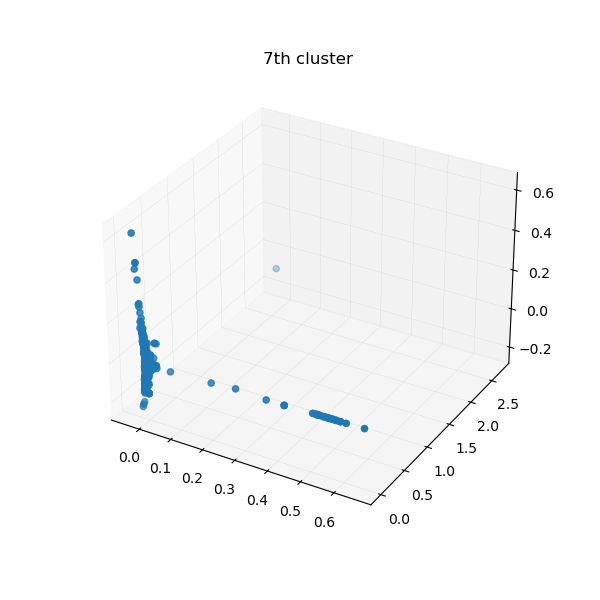

In [247]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_for_7th_3d[:, 0], Z_for_7th_3d[:, 1], Z_for_7th_3d[:, 2]) # plot the point (2,3,4) on the figure
plt.title(f'7th cluster')
plt.show()